In [1]:
import scanpy as sc
import scvi
import warnings
warnings.filterwarnings("ignore")

# pre-training-data

In [2]:
adata_batch1=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.077.h5ad')
adata_batch1.var_names_make_unique()
adata_batch1.obs['batch']='MERFISH_-1.077'

adata_batch2=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.078.h5ad')
adata_batch2.var_names_make_unique()
adata_batch2.obs['batch']='MERFISH_-1.078'

adata_list=[adata_batch1,adata_batch2]
adata_ref = sc.concat(adata_list, join="inner")
adata_ref.obs['type']='Pre-training data'

In [3]:
adata_ref

AnnData object with n_obs × n_vars = 89361 × 1122
    obs: 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'cluster_id_transfer', 'subclass_transfer', 'cluster_confidence_score', 'subclass_confidence_score', 'high_quality_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'slice', 'batch', 'type'
    obsm: 'X_CCF', 'X_spatial_coords', 'X_umap', 'spatial'

In [3]:
adata_ref.obs['ref_label']=adata_ref.obs['major_brain_region']

In [4]:
%%time
scvi.model.SCVI.setup_anndata(
    adata_ref,
    batch_key="batch",
)

# 2) trin SCVI
vae = scvi.model.SCVI(adata_ref)
vae.train()

# 3) scVI to scANVI
scanvi_ref = scvi.model.SCANVI.from_scvi_model(
    vae,
    labels_key="ref_label",
    unlabeled_category="Unknown",  
)

scanvi_ref.train()
scanvi_ref.save("/home/dbj/SpaLP/gittest/SpaLP/general/MERFISH/", overwrite=True)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA A800-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training:   0%|          | 0/90 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=90` reached.


INFO     Training for 10 epochs.                                                                                   


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 14min 27s, sys: 3.09 s, total: 14min 30s
Wall time: 12min 14s


# Query-data

In [14]:
adata_query=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.076.h5ad')
adata_query.var_names_make_unique()
adata_query.obs['batch']='MERFISH_-1.076'
adata_query.obs['type']='Inference data1'

In [15]:
adata_query.obs["ref_label"] = "Unknown"

In [16]:
model_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    "/home/dbj/SpaLP/gittest/SpaLP/general/MERFISH/",
    #labels_key="ref_label",
)
model_q.train(max_epochs=90)

adata_query.obs["predicted_label"] = model_q.predict()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File /home/dbj/SpaLP/gittest/SpaLP/general/MERFISH/model.pt already downloaded                            
INFO     Training for 90 epochs.                                                                                   


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training:   0%|          | 0/90 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=90` reached.


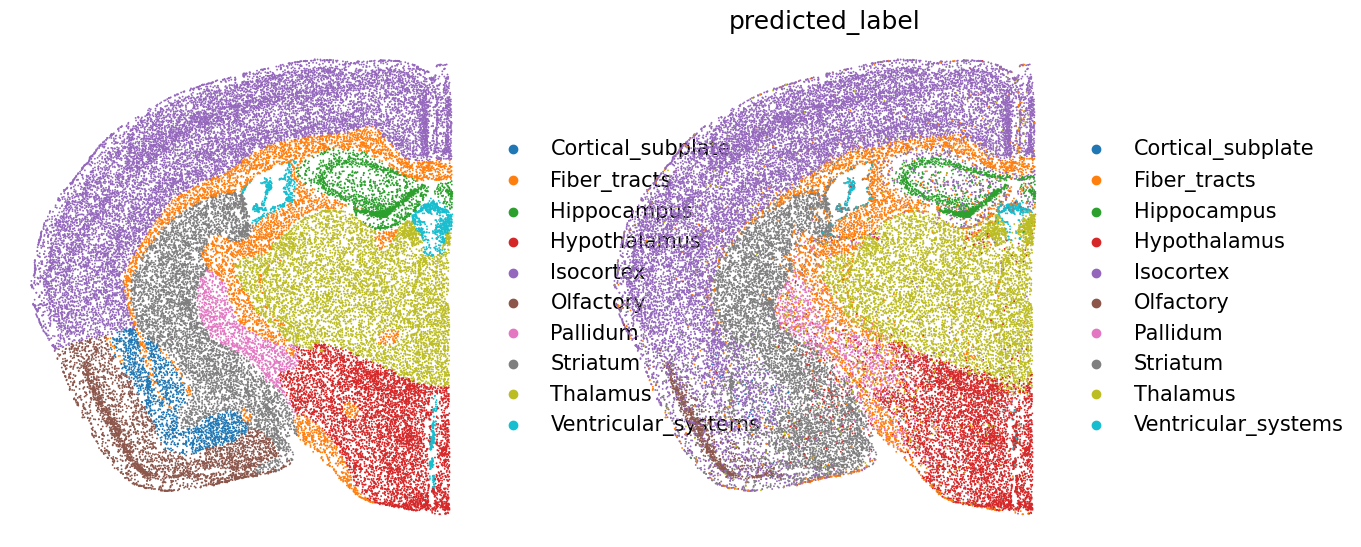

In [18]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata_query, basis="spatial",s=7,color=['major_brain_region','predicted_label'],colorbar_loc=None,title='',frameon=False)

In [20]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata_query.obs['major_brain_region'])
cluster_labels = np.array(adata_query.obs['predicted_label'])

nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)

ARI: 0.6189570672112852
NMI: 0.5659691057474491


In [21]:
adata_query.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/MERFISH/MERFISH_set6.h5ad',compression='gzip')